In [1]:
# 絶対使うであろうモジュールのインポート
import polars as pl

from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.preprocessing import StandardScaler

In [ ]:
is_colab = True
if is_colab:
    data_dir = 'https://raw.githubusercontent.com/utm529f/sukkiri-ml-codes-polars/main/datafiles'
else:
    data_dir = '../datafiles'

In [3]:
df = pl.read_csv(f'{data_dir}/Boston.csv') # csvの読み込み
df = df.fill_null(strategy='mean') # 欠損値補完
df = df.with_row_index().filter(pl.col('index') != 76) # 外れ値の行を削除

t = df[['PRICE']] # 正解データ抜き出し
x = df[['RM', 'PTRATIO', 'LSTAT']] # 特徴量抜き出し

# 標準化
sc = StandardScaler()
sc_x = sc.fit_transform(x)
sc2 = StandardScaler()
sc_t = sc2.fit_transform(t)

In [4]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, include_bias=False)
pf_x = pf.fit_transform(sc_x) # 2乗列と交互作用項の追加
pf_x.shape # 行数と列数

(99, 9)

In [5]:
pf.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2'], dtype=object)

In [6]:
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = train_test_split(pf_x,
    sc_t, test_size = 0.3, random_state = 0)
model = LinearRegression()
model.fit(x_train, y_train)

print('-- LinearRegression --')
print('train score:', model.score(x_train, y_train)) # 訓練データの決定係数
print('test score:', model.score(x_test, y_test)) # テストデータの決定係数

-- LinearRegression --
train score: 0.8710525685992707
test score: 0.7854929935582586


In [7]:
from sklearn.linear_model import Ridge # モジュールインポート
# モデルの作成
ridgeModel = Ridge(alpha = 10)
ridgeModel.fit(x_train, y_train) # 学習
print('-- Ridge --')
print('train score:', ridgeModel.score(x_train, y_train))
print('test score:', ridgeModel.score(x_test, y_test))

-- Ridge --
train score: 0.8607320524729507
test score: 0.8458730019328173


In [8]:
maxScore = 0
maxIndex = 0
# range関数により整数列を1～2000生成
for i in range(1, 2001):
    num = i/100
    ridgeModel = Ridge(random_state = 0, alpha = num)
    ridgeModel.fit(x_train, y_train)
    result = ridgeModel.score(x_test, y_test)
    if result > maxScore:
        maxScore = result
        maxIndex = num

print('-- Ridge alpha 1~2000 探索結果 --')
print('best alpha:', maxIndex)
print('best score:', maxScore)

-- Ridge alpha 1~2000 探索結果 --
best alpha: 17.62
best score: 0.852875480149763


In [9]:
print('-- 係数の合計 --')
print('Linear:', sum(abs(model.coef_)[0])) # 線形回帰の係数（絶対値）の合計
print('Ridge:', sum(abs(ridgeModel.coef_))) # リッジ回帰の合計

-- 係数の合計 --
Linear: 1.5566745983288364
Ridge: 1.2152800824026817


In [10]:
from sklearn.linear_model import Lasso

x_train, x_test, y_train, y_test = train_test_split(pf_x,
    sc_t, test_size = 0.3, random_state = 0)

# ラッソ回帰のモデル作成（alphaは正則化項につく定数）
model = Lasso(alpha = 0.1)
model.fit(x_train, y_train)

print('-- Lasso --')
print('train score:', model.score(x_train, y_train)) # 訓練データの決定係数
print('test score:', model.score(x_test, y_test)) # テストデータの決定係数

-- Lasso --
train score: 0.8224680202036665
test score: 0.858846785318774


In [11]:
weight = model.coef_ # 係数抜き出す
# 見やすいようにデータフレーム変換
pl.DataFrame({
    'feature': pl.Series(pf.get_feature_names_out()),
    'weight': pl.Series(weight)
})

feature,weight
str,f64
"""x0""",0.409426
"""x1""",-0.083104
"""x2""",-0.287714
"""x0^2""",0.150001
"""x0 x1""",-0.0
"""x0 x2""",-0.03745
"""x1^2""",-0.0
"""x1 x2""",0.0
"""x2^2""",0.0


In [12]:
import polars as pl
from sklearn.model_selection import train_test_split

df = pl.read_csv(f'{data_dir}/Boston.csv')
df = df.fill_null(strategy='mean')
#df = df.drop([76], axis = 0) # 外れ値の行を削除
x = df[:,'ZN':'LSTAT']
t = df['PRICE']

x_train, x_test, y_train, y_test = train_test_split(x, t,
    test_size = 0.3, random_state = 0)

In [13]:
# ライブラリインポート(回帰木バージョン)
from sklearn.tree import DecisionTreeRegressor

# 木の深さの最大を10と設定
model = DecisionTreeRegressor(max_depth = 10,
random_state = 0)
model.fit(x_train, y_train)
print('-- DecisionTreeRegressor --')
print('test score:', model.score(x_test, y_test)) # テストデータでの決定係数

-- DecisionTreeRegressor --
test score: 0.59433275545417


In [14]:
pl.DataFrame({
    'column': x.columns,
    'feature_importances': model.feature_importances_
})

column,feature_importances
str,f64
"""ZN""",0.000252
"""INDUS""",0.007301
"""CHAS""",0.0
"""NOX""",0.001967
"""RM""",0.759547
…,…
"""RAD""",0.000404
"""TAX""",0.013975
"""PTRATIO""",0.001913


# 練習問題

In [15]:
import polars as pl
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [16]:
df = pl.read_csv(f'{data_dir}/Bank.csv')
print(df.shape)
df.head()

(27128, 16)


id,age,job,marital,education,default,amount,housing,loan,contact,day,month,duration,campaign,previous,y
i64,i64,str,str,str,str,f64,str,str,str,i64,str,f64,i64,i64,i64
1,39,"""blue-collar""","""married""","""secondary""","""no""",1756.0,"""yes""","""no""","""cellular""",3,"""apr""",370.055237,1,0,1
2,51,"""entrepreneur""","""married""","""primary""","""no""",1443.0,"""no""","""no""","""cellular""",18,"""feb""",233.998933,10,0,1
3,36,"""management""","""single""","""tertiary""","""no""",436.0,"""no""","""no""","""cellular""",13,"""apr""",null,1,2,0
4,63,"""retired""","""married""","""secondary""","""no""",474.0,"""no""","""no""","""cellular""",25,"""jan""",252.525808,1,0,0
5,31,"""management""","""single""","""tertiary""","""no""",354.0,"""no""","""no""","""cellular""",30,"""apr""",null,1,2,0


In [17]:
# まず、ダミー変数化をしたいが、文字列の列が複数あるので抜き出す。
str_col_name = ['job', 'default', 'marital', 'education', 'housing', 'loan', 'contact', 'month']
str_df = df[str_col_name]
# 複数列を一気にダミー変数化
str_df2 = str_df.to_dummies(drop_first=True)

num_df = df.drop(str_col_name) # 数値列を抜き出す
df2 = pl.concat([num_df,str_df2,str_df], how='horizontal') # 結合(今後の集計の利便性も考慮してstr_dfも結合しておく)

In [18]:
# 訓練&検証データとテストデータに分割
train_val, test = train_test_split(df2, test_size=0.1, random_state=9)
train_val.head()

id,age,amount,day,duration,campaign,previous,y,job_admin.,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,default_yes,marital_divorced,marital_single,education_primary,education_tertiary,education_unknown,housing_no,loan_yes,contact_sending _document,contact_telephone,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,job,default,marital,education,housing,loan,contact,month
i64,i64,f64,i64,f64,i64,i64,i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,str,str,str,str,str,str,str,str
13379,46,0.0,10,378.293875,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,"""unemployed""","""no""","""married""","""tertiary""","""yes""","""no""","""cellular""","""jul"""
3801,41,-333.0,30,300.845752,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"""blue-collar""","""no""","""divorced""","""secondary""","""yes""","""no""","""cellular""","""jan"""
10399,30,5389.0,6,159.053623,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"""management""","""no""","""single""","""tertiary""","""no""","""no""","""cellular""","""aug"""
23402,39,255.0,5,334.802583,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,"""management""","""no""","""single""","""tertiary""","""yes""","""no""","""sending _document""","""may"""
26224,47,33.0,5,null,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"""services""","""no""","""single""","""secondary""","""yes""","""no""","""cellular""","""may"""


- 特徴量の当たりがついた
- しかし、そもそもこの線形回帰は外れ値の影響を強く受けるので調べる。

In [19]:
from sklearn.covariance import MinCovDet
num_df = train_val.drop(str_col_name)
num_df2 = num_df.drop_nulls()
mcd2 = MinCovDet(random_state=0, support_fraction=0.7)
mcd2.fit(num_df2.drop('id'))

,store_precision,True
,assume_centered,False
,support_fraction,0.7
,random_state,0


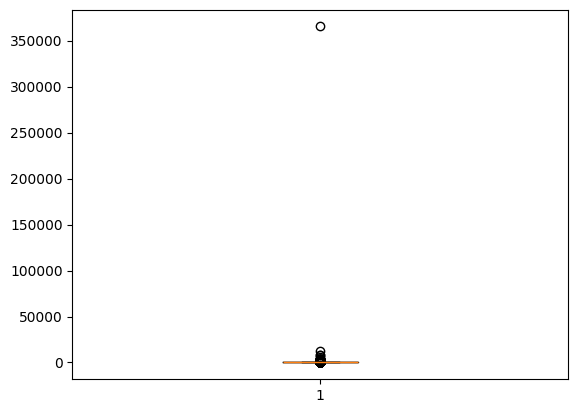

In [20]:
dis = mcd2.mahalanobis(num_df2.drop('id'))
dis = pl.Series(dis)
plt.boxplot(dis)
plt.show()
# 300000を超えるレコードのid特定して除外
id_no = (num_df2
    .with_columns(dis=dis) # dis の列追加
    .filter(pl.col('dis')>300000)
    .select('id').item() # id列の値取得
)
train_val2 = train_val.filter(pl.col('id')!=id_no)

In [21]:
# 欠損行を削除
not_nan_df = train_val2.drop_nulls()
temp_t = not_nan_df[['duration']]
temp_x = not_nan_df.drop(str_col_name)

# durationとyに関係があるという仮定が成り立つならば、適切な推定をするためには,
temp_x = temp_x.drop(['y', 'duration', 'id'])
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso, Ridge

a, b, c, d = train_test_split(temp_x, temp_t, random_state=0, test_size=0.2)
maxvalue = 0
v = 0
# 今回はLasso回帰を利用するので、特徴量選択はしない
for i in range(1, 42):
    val = i / 20
    model_liner = Lasso(random_state=0, alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner.fit(a, c)
    if maxvalue < model_liner.score(b, d):
        v = val
        maxvalue = model_liner.score(b, d)

print('-- Lasso --')
print('best alpha:', v)
print('best score:', maxvalue)

-- Lasso --
best alpha: 0.15
best score: 0.7303925573935854


In [22]:
model_liner = Lasso(random_state=0, alpha=v)
# 今回は予測させたいだけなので、標準化はしない
model_liner.fit(a, c)
# pl.Series(model_liner)

,alpha,0.15
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,0
,selection,'cyclic'


- 考え方をここで変える。`duration` と `y` に関係が強いという仮定が正しいならば、`duration` を推定するのに `y` を利用するのは合理的ではなかろうか？
- ただテストデータでは、`y` の値が本当に未知という状況で検証するのでテストデータでも `duration` が欠損している場合は上記 `model_liner` を利用する。

In [23]:
#欠損行を削除
not_nan_df = train_val2.drop_nulls()
temp_t = not_nan_df[['duration']]
temp_x = not_nan_df.drop(str_col_name)
#yを消さない
temp_x = temp_x.drop(['duration', 'id'])
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso, Ridge

a, b, c, d = train_test_split(temp_x, temp_t, random_state=0, test_size=0.2)
maxvalue = 0
v = 0
for i in range(1,42):
    val = i/20
    model_liner2 = Lasso(random_state=0,alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner2.fit(a,c)
    if maxvalue < model_liner2.score(b,d):
        v=val
        maxvalue = model_liner2.score(b,d)
        
print('-- Lasso --')
print('best alpha:', v)
print('best score:', maxvalue)

-- Lasso --
best alpha: 0.15
best score: 0.8192854538729204


In [24]:
# 結果
pl.DataFrame({
    'column': temp_x.columns,
    'coef': model_liner2.coef_
})

column,coef
str,f64
"""age""",3.685618
"""amount""",-0.00001
"""day""",-0.0
"""campaign""",-0.0
"""previous""",2.951848
…,…
"""month_mar""",-0.0
"""month_may""",0.0
"""month_nov""",-0.0


In [25]:
train_val3 = train_val.clone()
is_null = train_val3['duration'].is_null()
temp_x = train_val3.drop(str_col_name)

temp_x = temp_x.drop(['duration', 'id'])
temp_x = temp_x.filter(is_null)
pred_d = model_liner2.predict(temp_x)
# durationが欠損しているidと予測値のデータフレーム作成
train_val3_pred = (train_val3
    .filter(is_null)
    .select(
        'id',
        pred_duration = pred_d
    )
)
# 元のデータフレームにjoinして欠損値補間
train_val3 = (train_val3
    .join(train_val3_pred, how='left', on='id')
    .with_columns(
        # 予測値があればそれを、なければ元のdurationを使う
        pl.coalesce([pl.col('pred_duration'), pl.col('duration')]).alias('duration')
    )
    .drop('pred_duration')
)

(24415, 48)


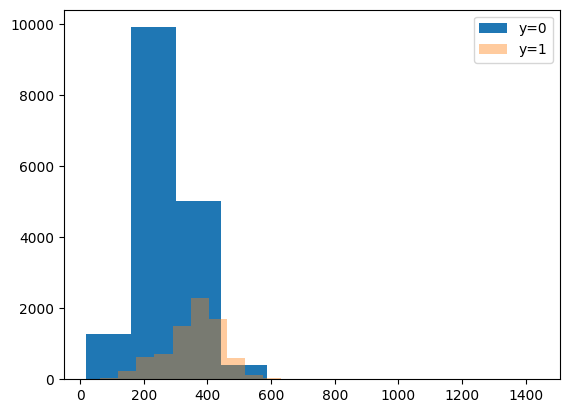

In [26]:
print(train_val3.shape)
# ヒストグラムの確認
duration_y0 = train_val3.filter(pl.col('y')==0).select('duration').to_series()
duration_y1 = train_val3.filter(pl.col('y')==1).select('duration').to_series()
plt.hist(duration_y0, label='y=0')
plt.hist(duration_y1, label='y=1', alpha=0.4)
plt.legend()
plt.show()

- `y=1` の方が、`duration` が大きい傾向がやっぱりありそう

In [27]:
train_val3["duration"].describe()

statistic,value
str,f64
"""count""",24415.0
"""null_count""",0.0
"""mean""",297.01212
"""std""",92.504765
"""min""",19.038719
"""25%""",227.002732
"""50%""",292.726974
"""75%""",362.291736
"""max""",1435.48804


In [28]:
#まず、さくっと学習できるようなlearn関数を定義する。
def learn(x, t, i):
    x_train, x_val, y_train, y_val = train_test_split(x, t, test_size=0.2, random_state=13)

    datas = [x_train,x_val,y_train,y_val]
    # id列の削除
    if 'id' in x_train.columns:
        x_train = x_train.drop('id')
        x_val = x_val.drop('id')

    #不均衡データに対応できるように、class_weight引数も設定
    model = tree.DecisionTreeClassifier(random_state=i, max_depth=i, class_weight='balanced')
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    
    
    val_score = model.score(x_val,y_val)
    return train_score, val_score, model, datas

t = train_val3['y']
x = train_val3.drop(str_col_name)
x = x.drop(['y', 'day'])
#とりあえず、for文で様々な木の深さでの正解率を調べてみる
print('max_depth, train_score, val_score')
for i in range(1, 15):
    s1, s2, model, datas = learn(x, t, i)
    print(i, s1, s2)

max_depth, train_score, val_score
1 0.754351832889617 0.7565021503174278
2 0.754351832889617 0.7565021503174278
3 0.7117038705713701 0.708171206225681
4 0.7706328077001843 0.7765717796436616
5 0.7595740323571575 0.7513823469178783
6 0.7923919721482695 0.7855826336268688
7 0.8189637517919311 0.8048330944091747
8 0.8383678066762237 0.8222404259676428
9 0.8562871185746468 0.8199877124718411
10 0.8733360638951464 0.8177349989760393
11 0.8900266229776777 0.820806881015769
12 0.9064611918902314 0.8169158304321114
13 0.920489453204997 0.8095433135367602
14 0.9362584476756093 0.811386442760598


- 深さ 8 検証データの正解率が 0.82 

In [29]:
#どのような間違い方をしているのか確認
s1, s2, model, datas = learn(x, t, 8)

#訓練データでの予測結果と実際の値の2軸で個数集計flagがFalseならば、検証データで集計
def syuukei(model, datas, flag=False):
    if flag:
        x_val = datas[0]
        y_val = datas[2]
    else:
        x_val = datas[1]
        y_val = datas[3]

    if 'id' in x_val.columns:
        x_val = x_val.drop('id')

    pre = model.predict(x_val)
    data = {
        "pred": pre,
        "true": y_val
    }
    tmp = pl.DataFrame(data)
    return tmp, tmp.pivot(index="true", on="pred", values="true", aggregate_function='len')

tmp, a = syuukei(model, datas, False)
print(a)

shape: (2, 3)
┌──────┬──────┬──────┐
│ true ┆ 0    ┆ 1    │
│ ---  ┆ ---  ┆ ---  │
│ i64  ┆ u32  ┆ u32  │
╞══════╪══════╪══════╡
│ 0    ┆ 2826 ┆ 557  │
│ 1    ┆ 311  ┆ 1189 │
└──────┴──────┴──────┘


In [30]:
def plot_2_bars_by_mean(false_df, true_df):
    labels = false_df.columns
    false_means = false_df.mean().transpose().to_series()
    true_means = true_df.mean().transpose().to_series()

    # 棒グラフの幅を定義
    width = 0.35

    # バーを左右にずらして描画
    x = np.arange(len(labels))
    rects1 = plt.bar(x - width/2, false_means, width, label='False')
    rects2 = plt.bar(x + width/2, true_means, width, label='True')
    plt.xticks(x, labels, rotation=90)
    plt.ylabel('Mean Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

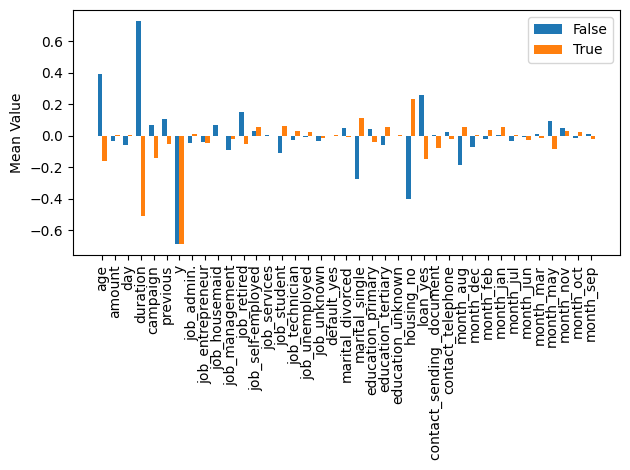

In [31]:
from sklearn.preprocessing import StandardScaler
false_ids = (
    pl.concat([datas[1], tmp], how='horizontal')
    .filter((pl.col('pred')==1)&(pl.col('true')==0))
    .select('id').to_series().to_list()
)
true_ids = (
    pl.concat([datas[1], tmp], how='horizontal')
    .filter((pl.col('pred')==0)&(pl.col('true')==0))
    .select('id').to_series().to_list()
)

sc = StandardScaler()
tmp2 = train_val3.drop(str_col_name)
tmp2 = tmp2.drop(['id'])
sc_data = sc.fit_transform(tmp2)
sc_df = pl.DataFrame(sc_data, schema=tmp2.columns)
sc_df = pl.concat([train_val3.select(pl.col('id')), sc_df], how='horizontal')

true_df = sc_df.filter(pl.col('id').is_in(true_ids)).drop('id')
false_df = sc_df.filter(pl.col('id').is_in(false_ids)).drop('id')

plot_2_bars_by_mean(false_df, true_df)

In [32]:
# 交互作用項を付けてみる
train_val4 = train_val3.clone()
train_val4 = train_val4.with_columns(
    (pl.col('duration') * pl.col('housing_no')).alias('du*hou'),
    (pl.col('duration') * pl.col('loan_yes')).alias('du*loan'),
    (pl.col('duration') * pl.col('age')).alias('du*age'),
)

t = train_val4['y']
x = train_val4.drop(str_col_name)
x = x.drop(['id', 'y', 'day'])
x.columns

['age',
 'amount',
 'duration',
 'campaign',
 'previous',
 'job_admin.',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'default_yes',
 'marital_divorced',
 'marital_single',
 'education_primary',
 'education_tertiary',
 'education_unknown',
 'housing_no',
 'loan_yes',
 'contact_sending _document',
 'contact_telephone',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'du*hou',
 'du*loan',
 'du*age']

In [33]:
# とりあえず、for文で様々な木の深さでの正解率を調べてみる
print('max_depth, train_score, val_score')
for i in range(5,15):
    s1, s2, model, datas = learn(x, t, i)
    print(i, s1, s2)

max_depth, train_score, val_score
5 0.7912144173663731 0.7884497235306164
6 0.8104648781486791 0.8040139258652468
7 0.8266946549252508 0.8160966618881835
8 0.8431292238378046 0.8210116731517509
9 0.8533688306369035 0.8124104034405079
10 0.868113864427606 0.8093385214007782
11 0.8879787016178579 0.8154822854802376
12 0.9024677452385829 0.8099528978087241
13 0.9189023141511365 0.8132295719844358
14 0.9317530206840058 0.8066762236330125


In [34]:
#深さ８で正解率81% 先ほどより低下した。よって交互作用項は取る。
train_val4 = train_val3.clone()
t = train_val4['y']
x = train_val4.drop(str_col_name)
x = x.drop(['id', 'y', 'day'])
i = 8
model = tree.DecisionTreeClassifier(random_state=i, max_depth=i, class_weight="balanced")
model.fit(x, t)

,criterion,'gini'
,splitter,'best'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,8
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [35]:
#テストデータでも調べる
test2 = test.clone()    
isnull = test2['duration'].is_null()
print(isnull.shape)
if isnull.sum()>0:
    temp_x = test2.drop(str_col_name)
    temp_x = temp_x.drop(['y', 'duration', 'id'])
    #print(temp_x.shape[0])
    temp_x = temp_x.filter(isnull)
    #ここではmodel_linerで調べる
    pred_d = model_liner.predict(temp_x)
    # durationが欠損しているidと予測値のデータフレーム作成
    test2_pred = (test2
        .filter(isnull)
        .select(
            'id',
            pred_duration = pred_d
        )
    )
    # 元のデータフレームにjoinして欠損値補間
    test2 = (test2
        .join(test2_pred, how='left', on='id')
        .with_columns(
            # 予測値があればそれを、なければ元のdurationを使う
            pl.coalesce([pl.col('pred_duration'), pl.col('duration')]).alias('duration')
        )
        .drop('pred_duration')
    )
    

x_test = test2.drop(str_col_name)
x_test = x_test.drop(['id', 'y', 'day'])
y_test = test['y']
x_test.columns
model.score(x_test, y_test)

(2713,)


0.7655731662366384

- もしかしたら、テストデータにも結構 `duration` の欠損値があるのかもしれない（テストデータなので確認できない）
- よって `model_liner` による不適切な `duration` 推定をしているかもしれない。。。

- 10章で仮説を3つ挙げた
- 精度が上がりづらい原因の仮説⇒ 
   1. 現状の線形回帰だと訓練&検証に過学習してしまい、テストデータにフィットしない。（そもそもテストデータではdurationがあまり関係していない？？）
   2. 純粋な決定木の限界？
   3. 現在考慮していない特徴量ももっとしっかりした方が良いのか？？

### 考察
- 今回、過学習しづらいlasso回帰を利用したので、10章よりかは１の可能性が減るはずだが、性能はあまり変わらない。
- 現状の知識では、1の可能性は低い。よって２か３の可能性を次章以降で探る（ただし、２と１の組み合わせなどは可能性としてあることに注意）